In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from src.globals import raw_data_dir, interim_data_dir
from src.visualization import plot_metrics

In [4]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

In [5]:
# check GPU visibility
tf.config.get_visible_devices(
    device_type='GPU'
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [70]:
# load meteo files and concat into one df
dfs = []

for file_ in [f'meteo-20{i}.csv' for i in range(16,20)]:
    df = pd.read_csv(raw_data_dir/file_, sep=';', encoding='latin-1')
    dfs.append(df)

df = pd.concat(dfs)

In [71]:
df.head()

,Messort,Parameter,Zeitpunkt,HMW
0,Salzburg Flughafen,Lufttemperatur [GradC],01.01.2016 00:30,"0,8"
1,Salzburg Flughafen,Lufttemperatur [GradC],01.01.2016 01:00,"1,2"
2,Salzburg Flughafen,Lufttemperatur [GradC],01.01.2016 01:30,"1,2"
3,Salzburg Flughafen,Lufttemperatur [GradC],01.01.2016 02:00,"1,1"
4,Salzburg Flughafen,Lufttemperatur [GradC],01.01.2016 02:30,"1,0"


In [72]:
# change decimal from comma to point and make numeric
df.HMW = df.HMW.str.replace(',','.')
df.HMW = pd.to_numeric(df.HMW, errors='coerce')

In [73]:
# 00:00 is encoded as 24:00
# fix:
# https://stackoverflow.com/questions/43359479/pandas-parsing-2400-instead-of-0000
days = df.Zeitpunkt.str[:2]
days.name = 'day'
months = df.Zeitpunkt.str[3:5]
months.name = 'month'
years = df.Zeitpunkt.str[6:10]
years.name = 'year'

hours = df.Zeitpunkt.str[11:13]
hours.name = 'hour'
minutes = df.Zeitpunkt.str[14:]
minutes.name = 'minute'

times = pd.DataFrame()

for i in [years, months, days, hours, minutes]:
    i = pd.to_numeric(i)
    times = pd.concat([times, i], axis=1)

df.Zeitpunkt = pd.to_datetime(times)


In [74]:
# remove duplicates in index otherwhise unstacking won't work
df.drop_duplicates(subset=['Messort', 'Parameter', 'Zeitpunkt'], inplace=True)

In [75]:
# unstack index to get metrics into columns
df.set_index(['Messort', 'Parameter', 'Zeitpunkt'], inplace=True)
df = df.unstack('Parameter')

In [76]:
# remove multilevel column names
df.columns = df.columns.droplevel()
df.columns.name = None

In [77]:
df.to_csv(interim_data_dir/'sbg-weather.csv', sep=';', encoding='utf8')

# Select data

In [85]:
df = pd.read_csv(interim_data_dir/'sbg-weather.csv', sep=';', encoding='utf8',
        index_col=['Messort', 'Zeitpunkt'])

In [78]:
# count available metrics per location
overall_counts = pd.DataFrame()

for location in df.index.get_level_values(0).unique():
    counts_per_loc = df.loc[location,:].notna().sum()
    counts_per_loc.name = location
    overall_counts = pd.concat([overall_counts, counts_per_loc], axis=1)

overall_counts = overall_counts.transpose()

In [79]:
overall_counts

,Luftdruck [hPa],Lufttemperatur [GradC],Sonnenscheindauer [min],Windgeschwindigkeit [m/s],Windrichtung [Grad],Windspitze [m/s],rel. Luftfeuchte [%]
Bergheim Siggerwiesen,69951,69548,0,69931,69930,69929,38278
Gaisberg Zistel,0,70107,0,0,0,0,70107
Hallein Eisenbahnbrücke,0,70073,0,70072,70072,70072,70072
Hallein Winterstall,70063,70061,0,70060,70060,70059,70060
Hallein Winterstall I (610 m),0,69456,0,0,0,0,69069
Hallein Winterstall II (700 m),0,69643,0,0,0,0,70108
Hallein Winterstall III (893 m),0,70042,0,0,0,0,70042
Haunsberg,70000,69998,0,69999,69999,69997,67479
Salzburg Fernheizwerk Mitte,0,0,0,70099,68712,70098,0
Salzburg Fernheizwerk Nord,0,0,0,64292,62329,64286,0


In [89]:
# use only locations for which all the majority of metrics is available
selected_metrics = ['Luftdruck [hPa]', 'Lufttemperatur [GradC]',
       'Windgeschwindigkeit [m/s]', 'Windrichtung  [Grad]', 'Windspitze [m/s]',
       'rel. Luftfeuchte [%]']

min_counts = overall_counts[selected_metrics].min(axis=1)
selected_locations = min_counts[min_counts>6.9e4].index
selected_locations

Index(['Hallein Winterstall', 'Salzburg Lehener Park',
       'St.Johann - Bezirkshauptmannschaft', 'Zell am See - Eishalle'],
      dtype='object')

# Visual exploration

In [86]:
df = df.loc[selected_locations, selected_metrics]

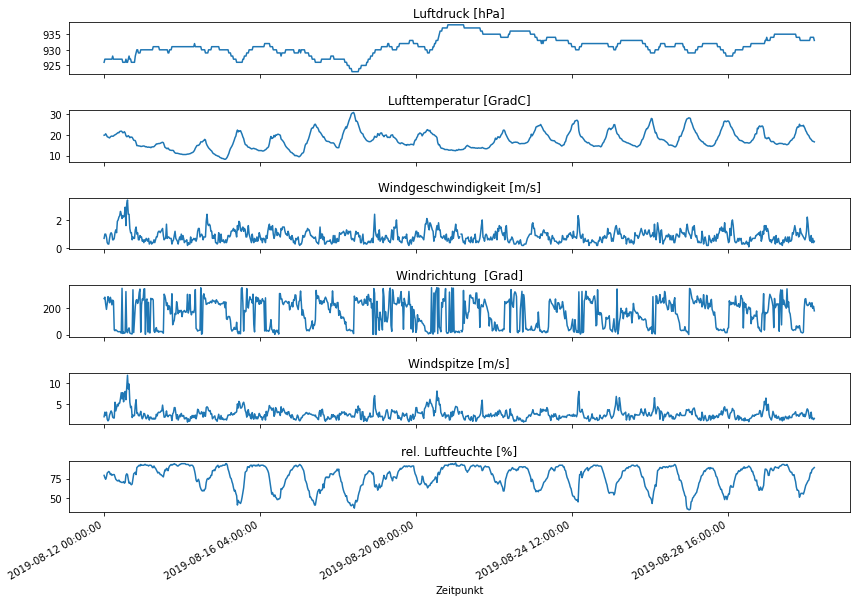

In [92]:
slc = slice('2019-08-12', '2019-08-31')

plot_metrics(df.loc['Zell am See - Eishalle'], metrics=selected_metrics, selected_slice=slc)

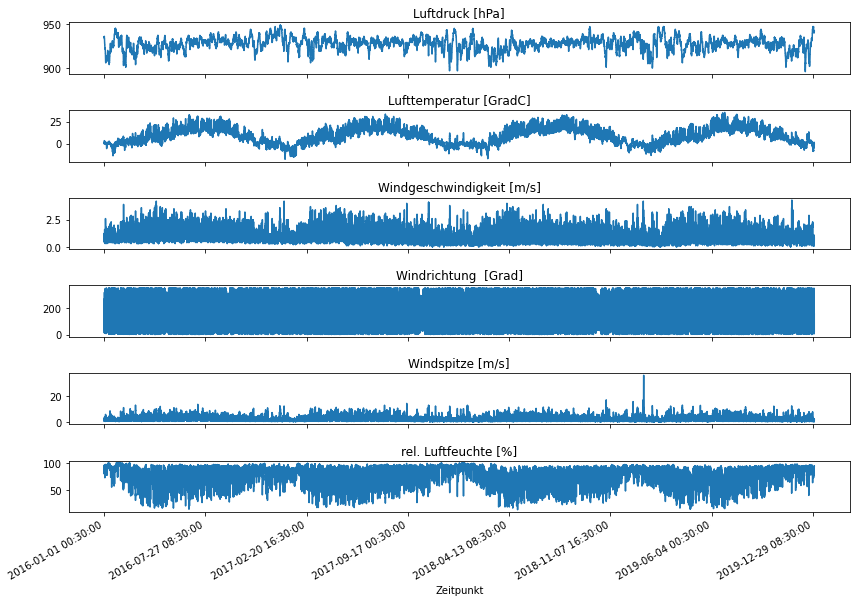

In [91]:
plot_metrics(df.loc['Zell am See - Eishalle'], metrics=selected_metrics)

In [ ]:
# TODO:
# feature engineering
# fill missings
# https://www.tensorflow.org/tutorials/structured_data/time_series#feature_engineering
# train test split
# scaling
# modelling